Hi, I am Wilson Xie. This is my first Kaggle project with my teammate Eric Wang.

Before we start the actual machine learning process, we import all the packages that we will need in the later process. We also load the training and testing dataset given by Kaggle.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/test.csv
/kaggle/input/titanic/train.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
train = pd.read_csv('/kaggle/input/titanic/train.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')

In [3]:
import seaborn as sns
import os
import matplotlib.pyplot as plt


from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
import re
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

In [4]:
titanic = train.copy()
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Distributions

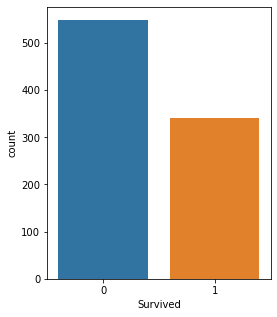

In [5]:
plt.figure(figsize=(4, 5)) #Counts for survived and non-survived passengers
sns.countplot(x='Survived', data=titanic)
plt.show()

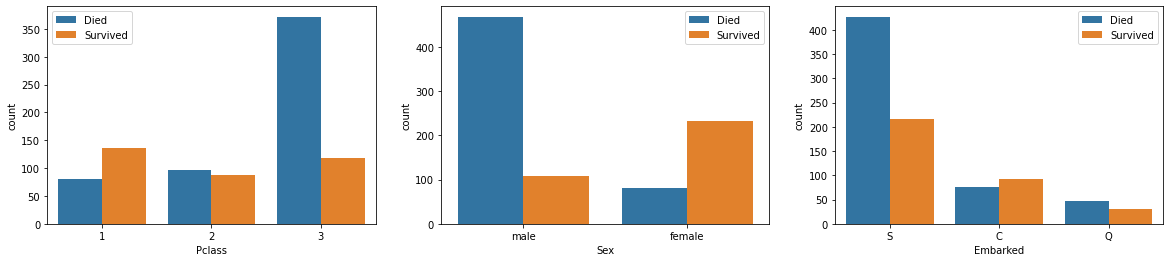

In [6]:
cat_cols = ['Pclass', 'Sex', 'Embarked']#Counts for survived and non-survived passengers distinguished by Pclass, sex, and embark location

fig, ax = plt.subplots(1, 3, figsize=(20, 4))
for ind, val in enumerate(cat_cols):
    sns.countplot(x=val, hue='Survived', data=titanic, ax=ax[ind])
    ax[ind].legend(['Died', 'Survived'])

Distribution of people's age who survived vs didn't survived

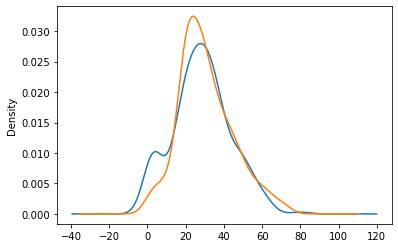

In [7]:
titanic[titanic['Survived'] == 1].Age.plot.kde() and titanic[titanic['Survived'] == 0].Age.plot.kde()

Distribution of people's fare who survived vs didn't survived

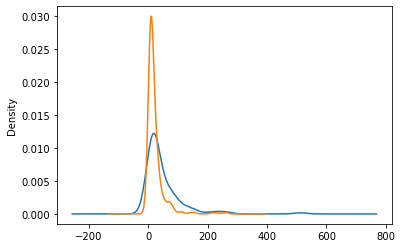

In [8]:
titanic[titanic['Survived'] == 1].Fare.plot.kde() and titanic[titanic['Survived'] == 0].Fare.plot.kde()

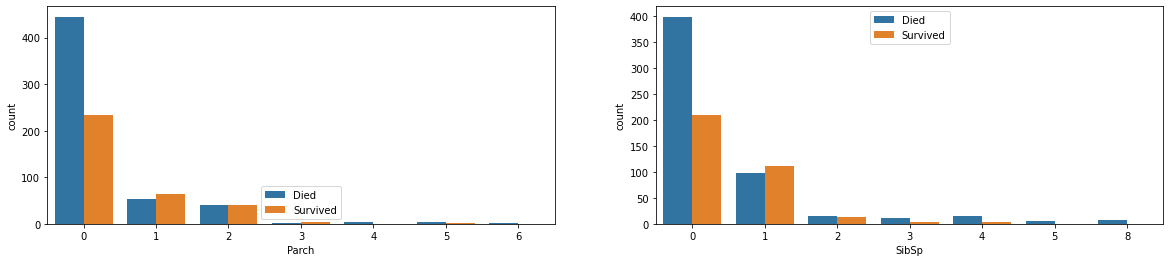

In [9]:
cat_cols = ['Parch', 'SibSp']#Counts for survived and non-survived passengers distinguished by the number of parents and siblings on board

fig, ax = plt.subplots(1, 2, figsize=(20, 4))
for ind, val in enumerate(cat_cols):
    sns.countplot(x=val, hue='Survived', data=titanic, ax=ax[ind])
    ax[ind].legend(['Died', 'Survived'])

In [10]:
titanic.describe() #Overview of the statistics

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [11]:
test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


There are missing values for the Age column in the training dataset, and there are missing values for the Age and Fare columns in the testing dataset. So we are going to impute missing values for those columns later on.

The describe() function does not check the missingness for the categorical columns. So columns like PassengerId, Ticket, and Embarked will be checked using different methods. Before we check the missingness for those columns, we decided to drop the PassengerId and Ticket columns because we believe those columns does not have any meaningful values for our machine learning. So we only check the missingness of Embarked column.

We created a class called StdScalerByGroup because we will use this class when we want to standardize Age column later on. Basically, this function groups the Pclass status by its mean and standard deviation, then the Z-value will be calculated based on the Age.

In [12]:
class StdScalerByGroup(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass

    def fit(self, X, y=None):
        df = pd.DataFrame(X)
        
        self.grps_ = [df.groupby(df.columns[0]).mean().to_dict('index'), df.groupby(df.columns[0]).std().to_dict('index')]

        return self

    def transform(self, X, y=None):
        try:
            getattr(self, "grps_")
        except AttributeError:
            raise RuntimeError("You must fit the transformer before tranforming the data!")
        

        df = pd.DataFrame(X)

        for i in df.columns[1:]:
        	mean = df[df.columns[0]].map(self.grps_[0]).map(lambda x: x[i])
        	std = df[df.columns[0]].map(self.grps_[1]).map(lambda x: x[i])
        	df[i] = (df[i] - mean) / std
        
        return df.drop(df.columns[0], axis = 1)

In [13]:
def final(dataset):
    #Drop unnecessary columns
    titanic = dataset.copy()
    titanic = titanic.drop(['PassengerId', 'Ticket', 'Cabin'], axis = 1)
    
    #Impute missingness. Median for numerical and mode for categorical
    titanic['Age'] = titanic[['Age']].fillna(titanic.Age.median())
    
    freq = titanic.Embarked.mode().iloc[0]
    titanic['Embarked'] = titanic[['Embarked']].fillna(freq)
    
    titanic['Fare'] = titanic[['Fare']].fillna(titanic.Fare.median())
    
    #Feature engineering
    
    #name
    #Regex to filter the name of the passengers to only their title. We believe that the name of a passenger has no meaning but the title of he/she does.
    l = []
    for i in titanic.Name.values:
        l.append(re.findall('[A-Z]{1}[a-z]+\.', i)[0])
    titanic.Name = l
    
    #We also see there are many rare titles in the names. We want to combine those uncommon ones so then it would be easier to do the one-hot encoding.
    titanic['Name'] = titanic['Name'].replace(['Lady.', 'Countess.','Capt.', 'Col.', 'Don.', 'Dr.', 'Major.', 'Rev.', 'Sir.', 'Jonkheer.', 'Dona.'], 'Rare')

    titanic['Name'] = titanic['Name'].replace('Mlle.', 'Miss.')
    titanic['Name'] = titanic['Name'].replace('Ms.', 'Miss.')
    titanic['Name'] = titanic['Name'].replace('Mme.', 'Mrs.')
    
    title_mapping = {"Mr.": 1, "Miss.": 2, "Mrs.": 3, "Master.": 4, "Rare.": 5}
    titanic['Name'] = titanic['Name'].map(title_mapping)
    titanic['Name'] = titanic['Name'].fillna(0)
    

    
    #family
    #We want to combine the siblings and parents together in a new column, called "Family".
    titanic['Family'] = titanic['SibSp'] + titanic['Parch']
    
    
    #sex
    #Converting categorical to numerical
    def sex(n):
        if n == 'male':
            return 1
        else:
            return 0
    titanic['Sex'] = titanic.Sex.apply(sex)
    
    #embarked
    places = titanic.Embarked.unique()
    pl = titanic['Embarked'].apply(lambda x: pd.Series(x == places, index=places, dtype=float))
    titanic = pd.concat([titanic, pl], axis = 1)
    
    #Drop unnecessary columns again
    titanic = titanic.drop([ 'Embarked'], axis = 1)

    #age
    #Z-values for Age column
    g = titanic[['Pclass', 'Age']]
    std = StdScalerByGroup().fit(g)
    titanic['Age'] = std.transform(g)
    
    return titanic

Machine Learning process:
Random forest classifier.

In [14]:
copy = final(titanic)


X = copy.drop('Survived', axis = 1)
y = copy.Survived
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 1)
ml = Pipeline([('r', RandomForestClassifier(n_estimators=500,max_depth=6,min_samples_leaf=2,max_features='sqrt'))])
ml.fit(X_train, y_train)

Pipeline(steps=[('r',
                 RandomForestClassifier(max_depth=6, max_features='sqrt',
                                        min_samples_leaf=2,
                                        n_estimators=500))])

In [15]:
ml.predict(X_test)

array([0])

In [16]:
ml.score(X_test, y_test)

0.0

In [17]:
preds = ml.predict(final(test))

In [18]:
ml.score(X,y)

0.8552188552188552

In [19]:
submission = pd.DataFrame({
        "PassengerId": test["PassengerId"],
        "Survived": preds
    })

In [20]:
submission.to_csv('submission.csv', index=False)